In [1]:

import cartopy.feature as feature
import cartopy.crs as ccrs
from calendar import month_abbr
import matplotlib.dates as mdates
from pathlib import Path 
import subprocess 
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import datetime
import numpy as np
import pandas as pd
import xarray
import xesmf
import os 
from glob import glob
from plot_common import autoextend_colorbar, corners, get_map_norm, open_var, add_ticks, annotate_skill, save_figure
from scipy.stats import ttest_1samp
import statistics
import scipy 
import xgcm

In [2]:
from functools import reduce
# also import pandas, xarray, etc as usual

def shift_time_to_end(before, on):
    """
    Given two xarray dataarrays/sets, both 
    with same frequency and an index named time,
    this will add an appropriate number of years to
    the second (on) so that the time begins after
    the first (before). 
    """
    delta_years = int(before['time.year'][-1]) - int(on['time.year'][0]) + 1
    shifted = on.assign_coords(time=on.indexes['time'] + pd.DateOffset(years=delta_years))
    return shifted

nens = 5
res = 'med'
members = []
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_{res}atm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    ssh = open_var(root, 'ocean_monthly', 'ssh').sel(time=slice('1997', None))
    members.append(ssh)
allconcat = reduce(lambda left, right: xarray.concat((left, shift_time_to_end(left, right)), dim='time'), members)

In [3]:
nens = 5
res = 'low'
members = []
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_{res}atm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    ssh = open_var(root, 'ocean_monthly', 'ssh').sel(time=slice('1997', None))
    members.append(ssh)
allconcatlow = reduce(lambda left, right: xarray.concat((left, shift_time_to_end(left, right)), dim='time'), members)

In [4]:
def compute_gs(ssh, data_grid=None):
    lons = np.arange(360-72, 360-51.9, 1)
    lats = np.arange(36, 42, 0.1)
    target_grid = {'lat': lats, 'lon': lons}

    if data_grid is None:
        data_grid = {'lat': ssh.lat, 'lon': ssh.lon}

    ssh_to_grid = xesmf.Regridder(
        data_grid,
        target_grid,
        method='bilinear'
    )

    # Interpolate the SSH data onto the index grid.
    regridded = ssh_to_grid(ssh)

    # Find anomalies relative to the calendar month mean SSH over the full model run.
    anom = regridded.groupby('time.month') - regridded.groupby('time.month').mean('time')

    # For each longitude point, the Gulf Stream is located at the latitude with the maximum SSH anomaly variance.
    stdev = anom.std('time')
    amax = stdev.argmax('lat').compute()
    gs_points = stdev.lat.isel(lat=amax).compute()

    # The index is the mean latitude of the Gulf Stream, divided by the standard deviation of the mean latitude of the Gulf Stream.
    index = ((anom.isel(lat=amax).mean('lon')) / anom.isel(lat=amax).mean('lon').std('time')).compute()

    # Move times to the beginning of the month to match observations.
    monthly_index = index.to_pandas().resample('1MS').first()
    return monthly_index, gs_points

In [5]:
rootmed1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootlow1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootmed2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod') 
rootlow2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_2/gfdl.ncrc5-intel22-prod')
rootmed3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod') 
rootlow3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_3/gfdl.ncrc5-intel22-prod')
rootmed4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod') 
rootlow4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_4/gfdl.ncrc5-intel22-prod')
rootmed5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod') 
rootlow5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_5/gfdl.ncrc5-intel22-prod')

In [6]:
sstwholemed1 = open_var(rootmed1, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow1 = open_var(rootlow1, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed2 = open_var(rootmed2, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow2 = open_var(rootlow2, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))
sstwholemed3 = open_var(rootmed3, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholelow3 = open_var(rootlow3, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed4 = open_var(rootmed4, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))  
sstwholelow4 = open_var(rootlow4, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sstwholemed5 = open_var(rootmed5, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007"))  
sstwholelow5 = open_var(rootlow5, 'ocean_monthly', 'tos').resample(time = "1MS").first().sel(time=slice("1997","2007")) 

In [7]:
sshwholemed1 = open_var(rootmed1, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow1 = open_var(rootlow1, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed2 = open_var(rootmed2, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow2 = open_var(rootlow2, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed3 = open_var(rootmed3, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow3 = open_var(rootlow3, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed4 = open_var(rootmed4, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow4 = open_var(rootlow4, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholemed5 = open_var(rootmed5, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 
sshwholelow5 = open_var(rootlow5, 'ocean_monthly', 'ssh').resample(time = "1MS").first().sel(time=slice("1997","2007")) 

In [10]:
modelgsiindexmed1, modelgsipointsmed1 = compute_gs(sshwholemed1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow1, modelgsipointslow1 = compute_gs(sshwholelow1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed2, modelgsipointsmed2 = compute_gs(sshwholemed2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow2, modelgsipointslow2 = compute_gs(sshwholelow2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed3, modelgsipointsmed3 = compute_gs(sshwholemed3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow3, modelgsipointslow3 = compute_gs(sshwholelow3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed4, modelgsipointsmed4 = compute_gs(sshwholemed4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow4, modelgsipointslow4 = compute_gs(sshwholelow4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed5, modelgsipointsmed5 = compute_gs(sshwholemed5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow5, modelgsipointslow5 = compute_gs(sshwholelow5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order in

In [9]:
model_grid = xarray.open_dataset('../data/geography/ocean_static.nc')

In [11]:
medgsi_index, medgsipts = compute_gs(allconcat, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'})) 

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 130 times more chunks
  return self.array[key]


In [12]:
lowgsi_index, lowgsipts = compute_gs(allconcatlow, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'})) 

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 130 times more chunks
  return self.array[key]


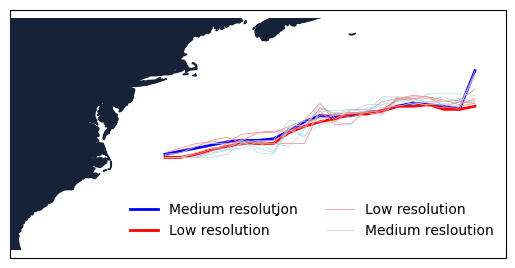

In [13]:
_LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#152238'
    )

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.add_feature(_LAND_50M)

ax.plot(medgsipts.lon-360, medgsipts.lat, linewidth=2, label='Medium resolution', color='blue')
ax.plot(lowgsipts.lon-360, lowgsipts.lat, linewidth=2, label='Low resolution', color='red')

ax.plot(modelgsipointsmed1.lon-360, modelgsipointsmed1, c='lightcoral', linewidth='.5', label = 'Low resolution')
ax.plot(modelgsipointslow1.lon-360, modelgsipointslow1, c='lightblue', linewidth='.5', label = 'Medium resloution') 
ax.plot(modelgsipointsmed2.lon-360, modelgsipointsmed2, c='lightcoral', linewidth='.5')
ax.plot(modelgsipointslow2.lon-360, modelgsipointslow2, c='lightblue', linewidth='.5') 
ax.plot(modelgsipointsmed3.lon-360, modelgsipointsmed3, c='lightcoral', linewidth='.5')
ax.plot(modelgsipointslow3.lon-360, modelgsipointslow3, c='lightblue', linewidth='.5') 
ax.plot(modelgsipointsmed4.lon-360, modelgsipointsmed4, c='lightcoral', linewidth='.5')
ax.plot(modelgsipointslow4.lon-360, modelgsipointslow4, c='lightblue', linewidth='.5') 
ax.plot(modelgsipointsmed5.lon-360, modelgsipointsmed5, c='lightcoral', linewidth='.5')
ax.plot(modelgsipointslow5.lon-360, modelgsipointslow5, c='lightblue', linewidth='.5')

ax.legend(loc = 'lower right', frameon=False, ncol=2, markerscale=4.0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([-82, -50, 30, 44])

ax.spines['geo'].set_visible(False)
plt.rcParams['figure.dpi'] = 1200
# Show the plot
plt.show()

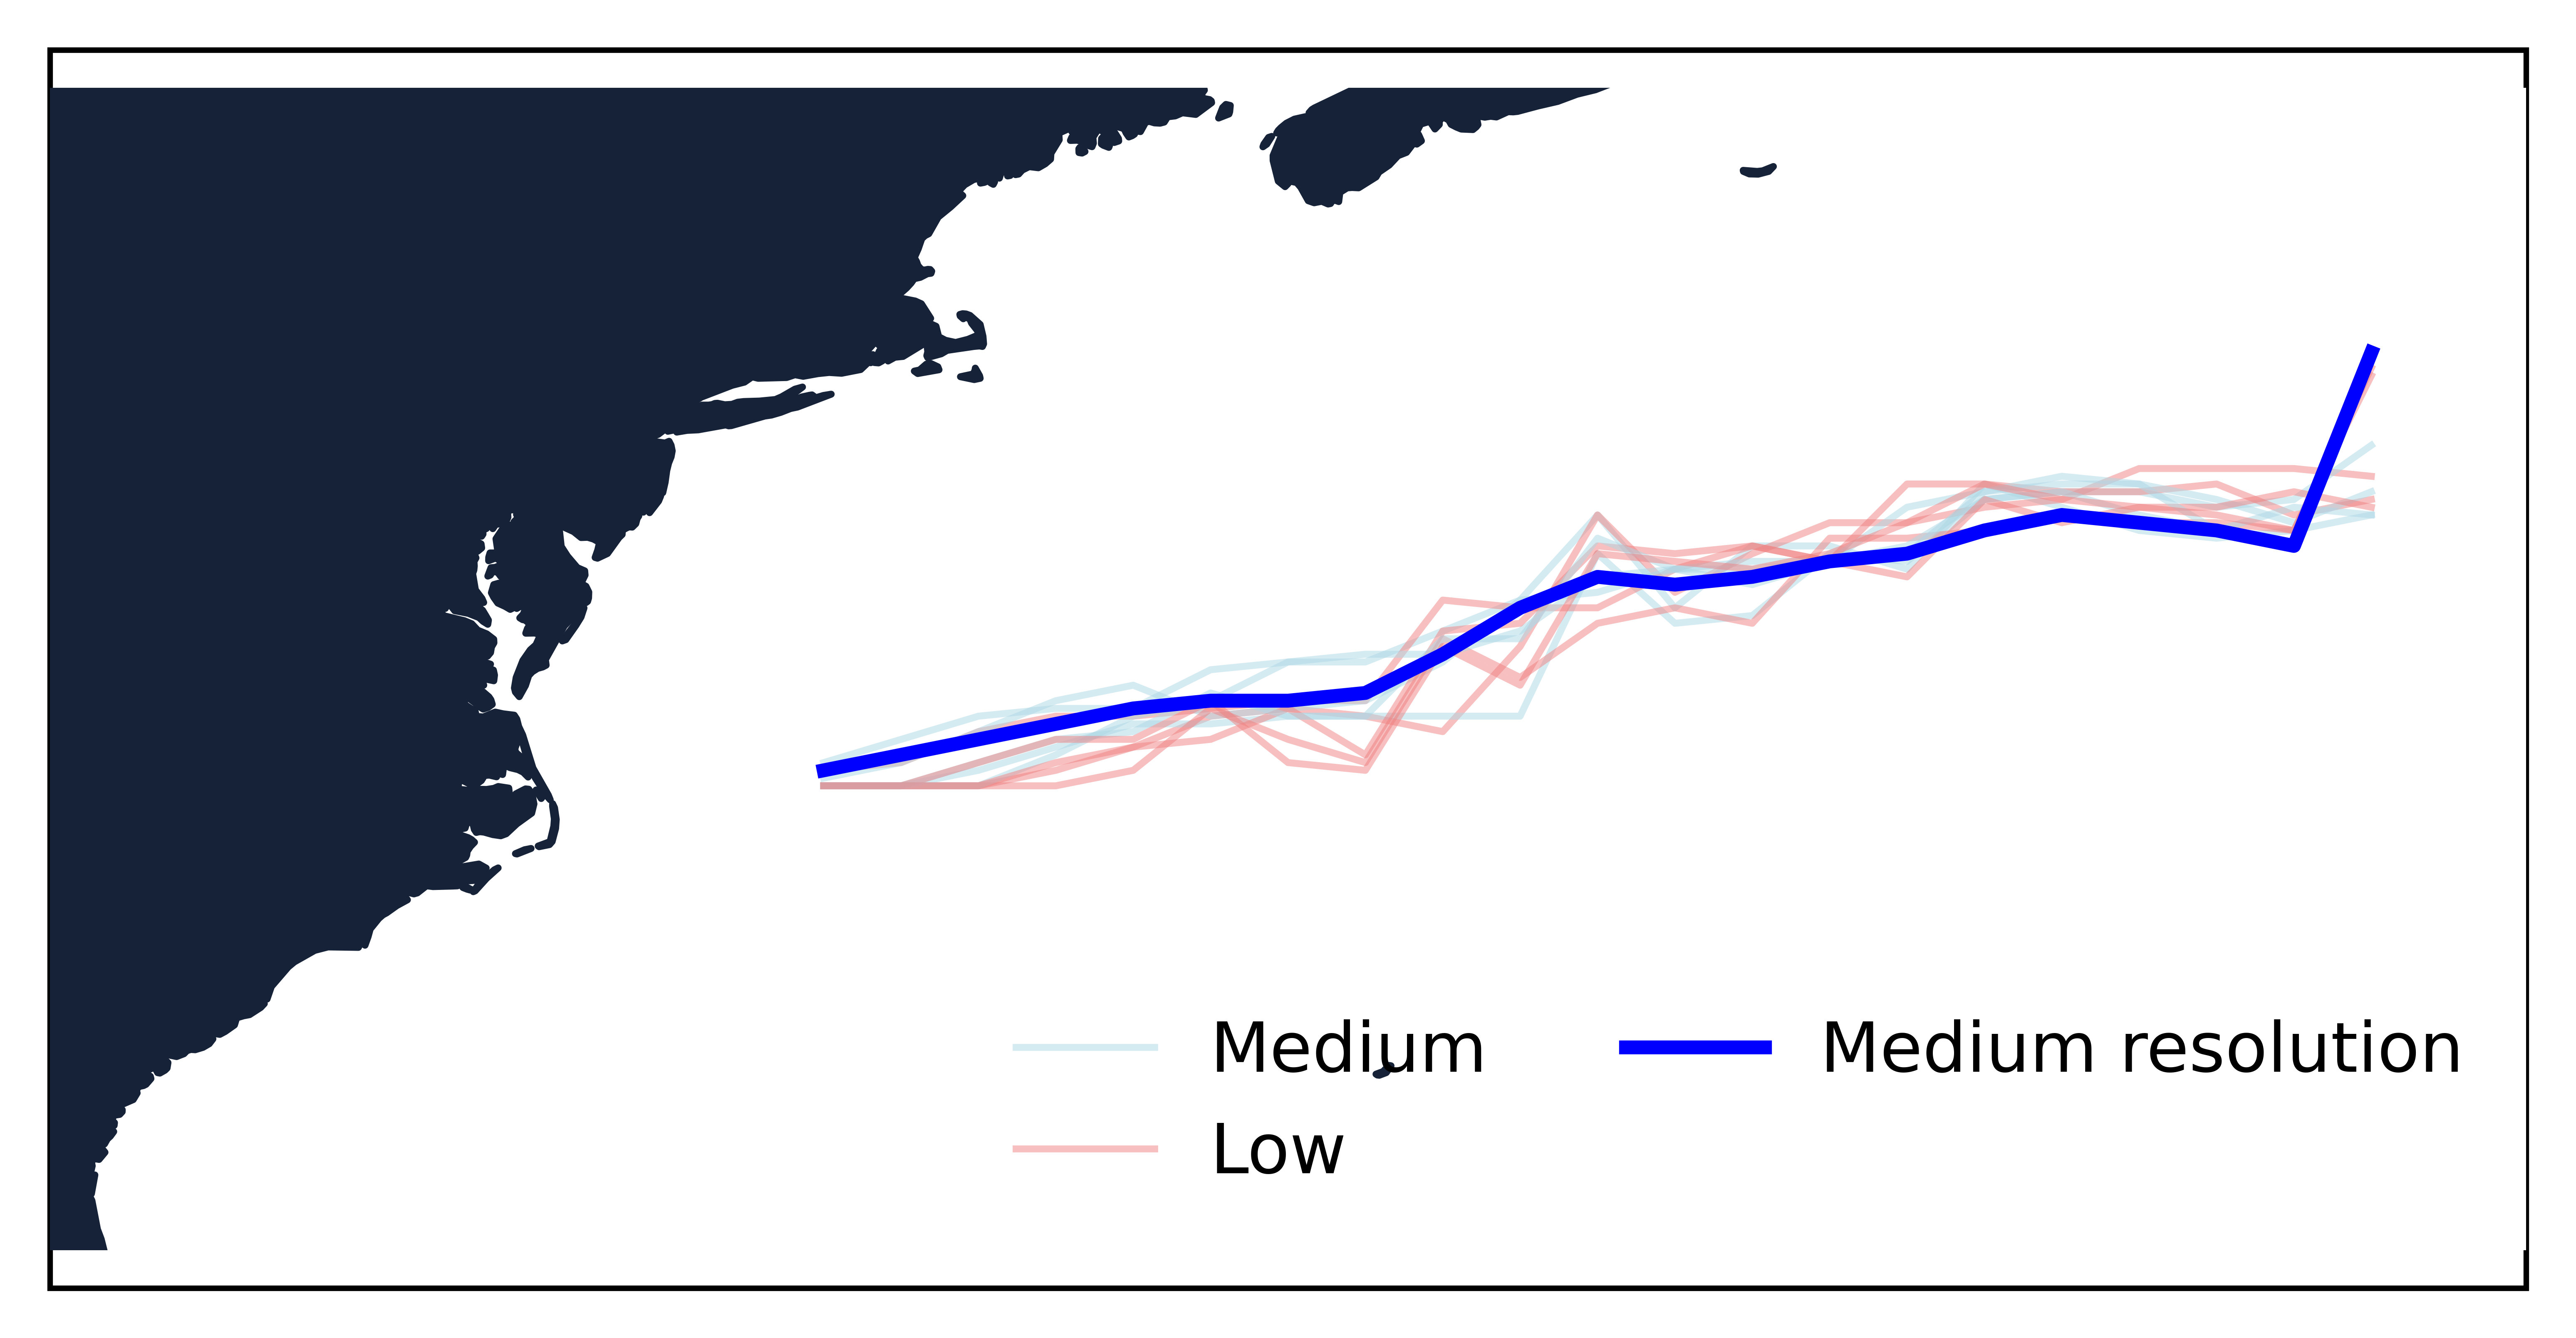

In [14]:
_LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#152238'
    )

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.add_feature(_LAND_50M)

ax.plot(modelgsipointsmed1.lon-360, modelgsipointsmed1, c='lightblue', linewidth='1', alpha=0.5, label = 'Medium')
ax.plot(modelgsipointslow1.lon-360, modelgsipointslow1, c='lightcoral', linewidth='1', alpha=0.5, label = 'Low') 
ax.plot(modelgsipointsmed2.lon-360, modelgsipointsmed2, c='lightblue', linewidth='1', alpha=0.5)
ax.plot(modelgsipointslow2.lon-360, modelgsipointslow2, c='lightcoral', linewidth='1', alpha=0.5) 
ax.plot(modelgsipointsmed3.lon-360, modelgsipointsmed3, c='lightblue', linewidth='1', alpha=0.5)
ax.plot(modelgsipointslow3.lon-360, modelgsipointslow3, c='lightcoral', linewidth='1', alpha=0.5) 
ax.plot(modelgsipointsmed4.lon-360, modelgsipointsmed4, c='lightblue', linewidth='1', alpha=0.5)
ax.plot(modelgsipointslow4.lon-360, modelgsipointslow4, c='lightcoral', linewidth='1', alpha=0.5) 
ax.plot(modelgsipointsmed5.lon-360, modelgsipointsmed5, c='lightblue', linewidth='1', alpha=0.5)
ax.plot(modelgsipointslow5.lon-360, modelgsipointslow5, c='lightcoral', linewidth='1', alpha=0.5)

ax.plot(medgsipts.lon-360, medgsipts.lat, linewidth=2, label='Medium resolution', color='blue')
#ax.plot(lowgsipts.lon-360, lowgsipts.lat, linewidth=2, label='Low resolution', color='red')

ax.legend(loc = 'lower right', frameon=False, ncol=2, markerscale=4.0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([-82, -50, 30, 44])

ax.spines['geo'].set_visible(False)
plt.rcParams['figure.dpi'] = 1200
# Show the plot
plt.show()

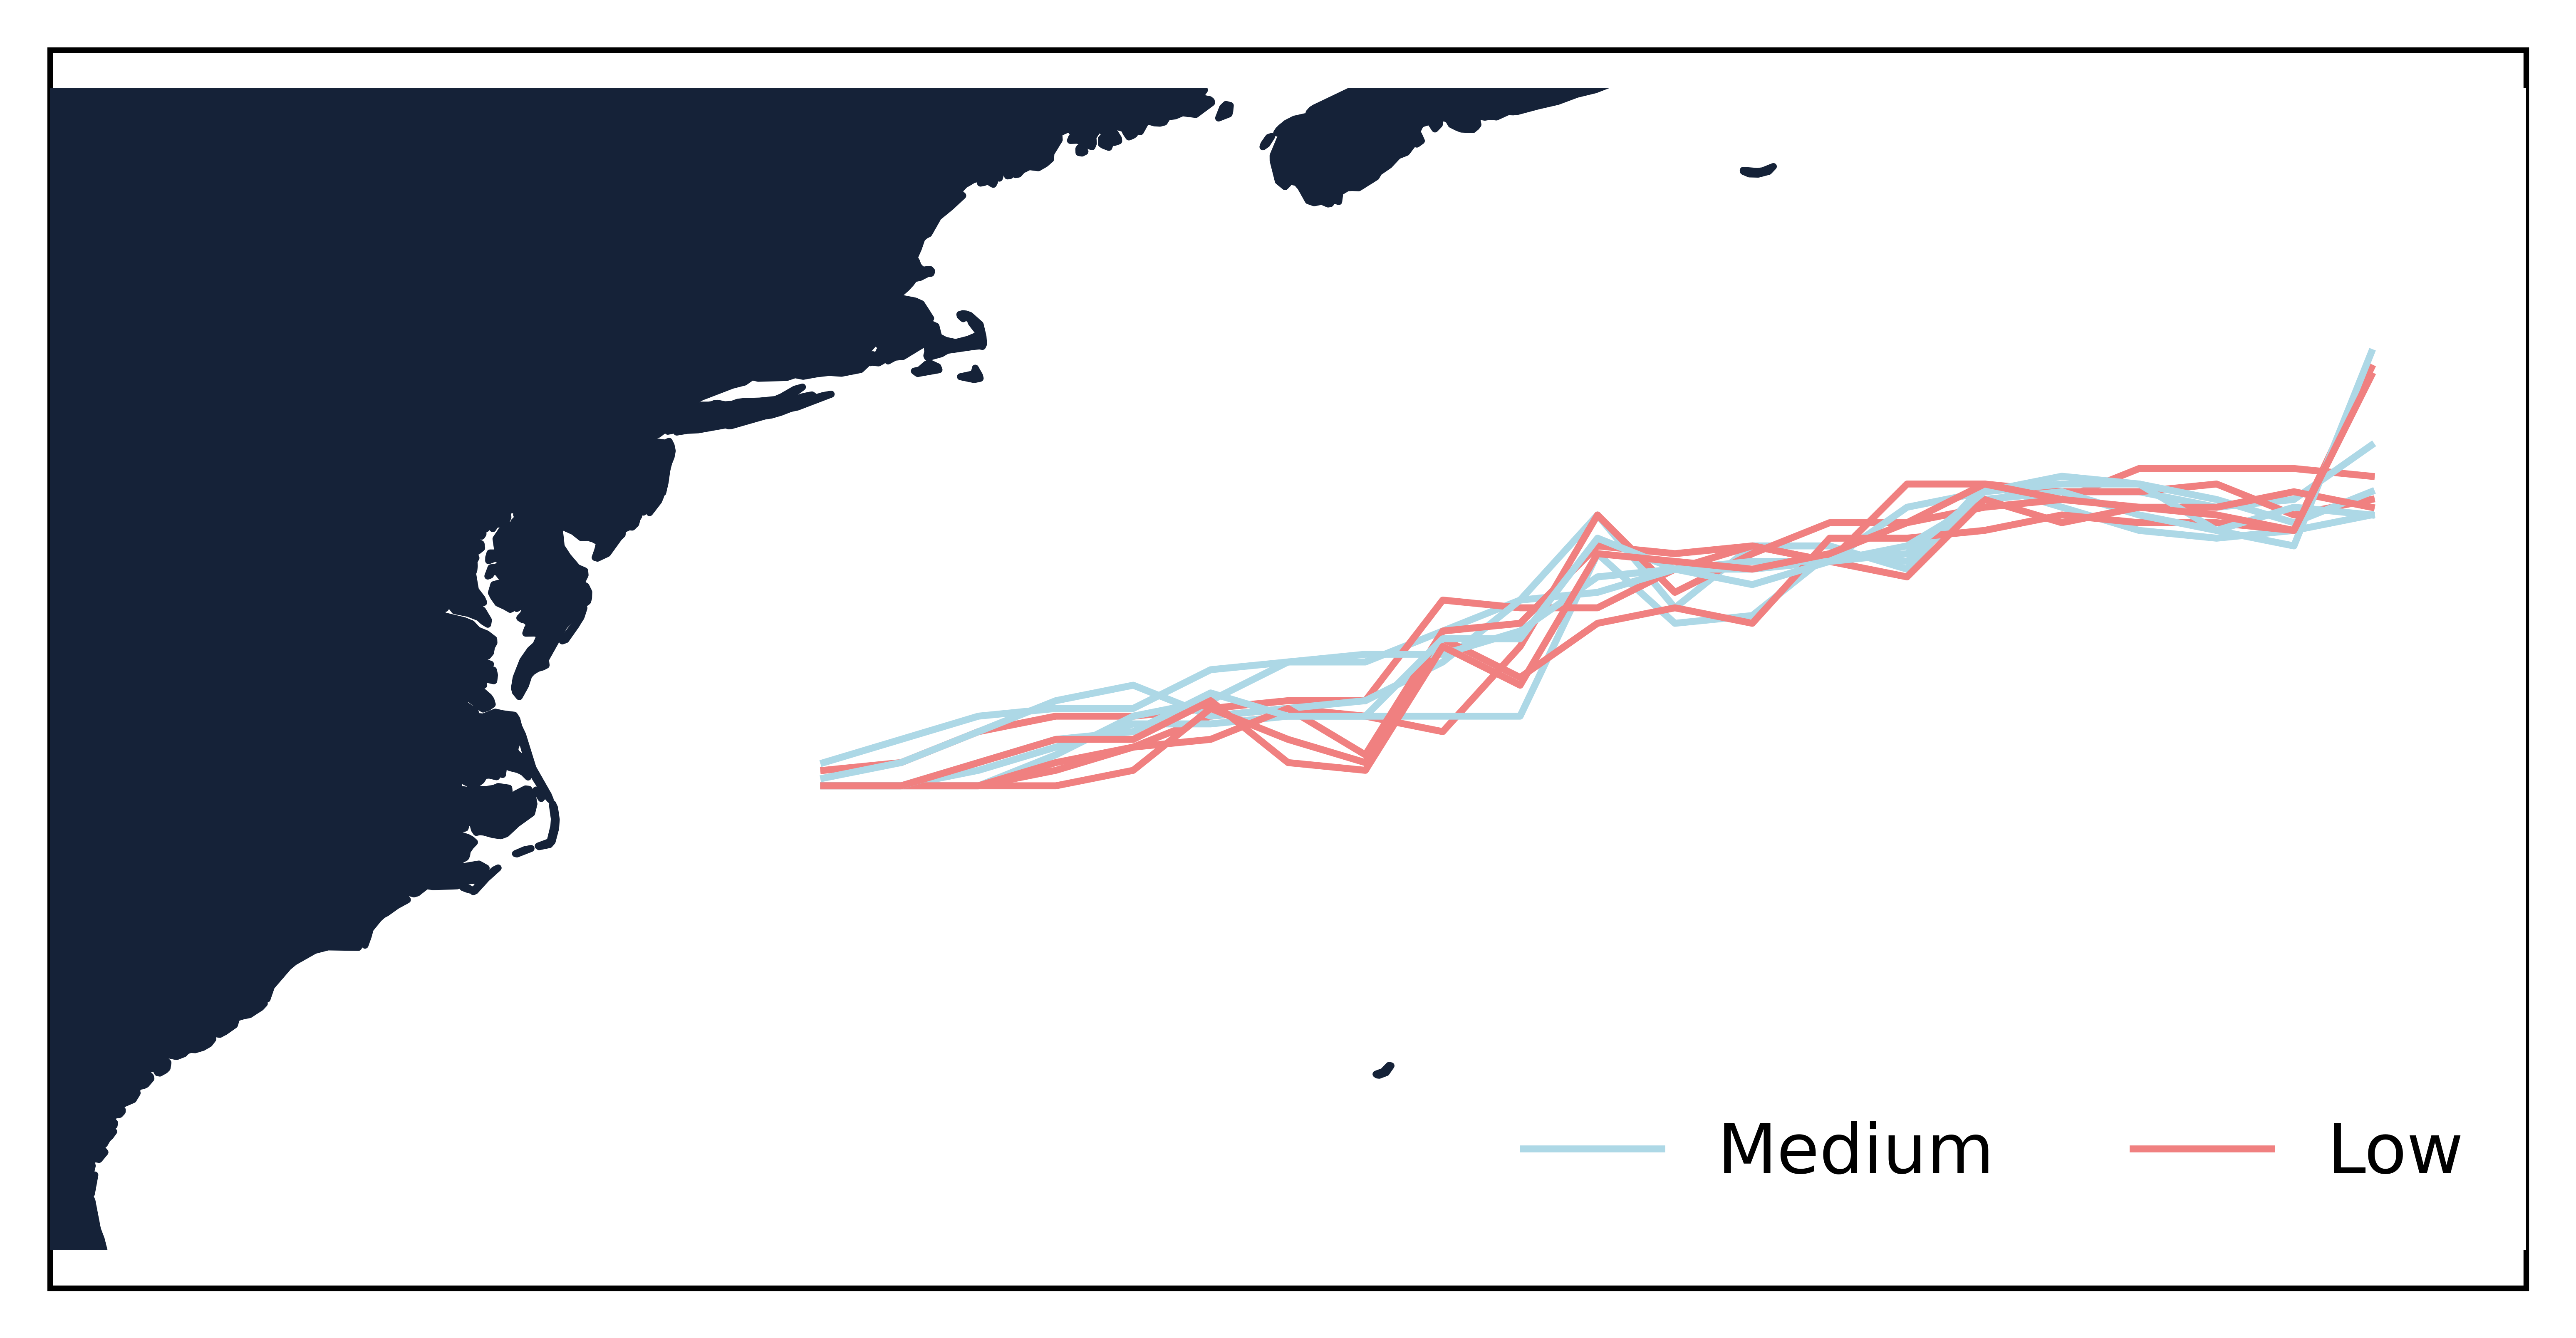

In [15]:
_LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#152238'
    )

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.add_feature(_LAND_50M)

ax.plot(modelgsipointsmed1.lon-360, modelgsipointsmed1, c='lightblue', linewidth='1', label = 'Medium')
ax.plot(modelgsipointslow1.lon-360, modelgsipointslow1, c='lightcoral', linewidth='1', label = 'Low') 
ax.plot(modelgsipointsmed2.lon-360, modelgsipointsmed2, c='lightblue', linewidth='1')
ax.plot(modelgsipointslow2.lon-360, modelgsipointslow2, c='lightcoral', linewidth='1') 
ax.plot(modelgsipointsmed3.lon-360, modelgsipointsmed3, c='lightblue', linewidth='1')
ax.plot(modelgsipointslow3.lon-360, modelgsipointslow3, c='lightcoral', linewidth='1') 
ax.plot(modelgsipointsmed4.lon-360, modelgsipointsmed4, c='lightblue', linewidth='1')
ax.plot(modelgsipointslow4.lon-360, modelgsipointslow4, c='lightcoral', linewidth='1') 
ax.plot(modelgsipointsmed5.lon-360, modelgsipointsmed5, c='lightblue', linewidth='1')
ax.plot(modelgsipointslow5.lon-360, modelgsipointslow5, c='lightcoral', linewidth='1')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([-82, -50, 30, 44])

ax.legend(loc = 'lower right', frameon=False, ncol=2, markerscale=4.0)

ax.spines['geo'].set_visible(False)
plt.rcParams['figure.dpi'] = 1200
# Show the plot
plt.show()